In [ ]:
import tensorflow as tf

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
import matplotlib.pyplot as plt
from google.colab import files

%matplotlib inline

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

## 1) train에 사용된 파일 다운로드드

In [ ]:
%cd darknet/data

/content/darknet/data


In [ ]:
!gdown https://drive.google.com/uc?id=1FEdYMujEvJHkhdh69JRG9BF2gYt0jQQl
!gdown https://drive.google.com/uc?id=1S-PK9QPZ_VxcSYIcZ5L8Uh75ldjQgz0P
!gdown https://drive.google.com/uc?id=1nhMxNlt4usDqUR0AGfiIJFeb4n2l08ID
!gdown https://drive.google.com/uc?id=1LJpV2fD1AU3C86TVQeQQZzcmJeDuW3Vu
!gdown https://drive.google.com/uc?id=1-6D1IQpD5vMRAmP4VCnFcqUrC_scUQK6
!gdown https://drive.google.com/uc?id=11AvLNnVZsFW45LQcAvbbtV1Mp1fwZeBu

Downloading...
From: https://drive.google.com/uc?id=1S-PK9QPZ_VxcSYIcZ5L8Uh75ldjQgz0P
To: /content/darknet/data/sea_data.data
100% 125/125 [00:00<00:00, 250kB/s]
Downloading...
From: https://drive.google.com/uc?id=1nhMxNlt4usDqUR0AGfiIJFeb4n2l08ID
To: /content/darknet/data/ClassNames.names
100% 53.0/53.0 [00:00<00:00, 103kB/s]
Downloading...
From: https://drive.google.com/uc?id=1LJpV2fD1AU3C86TVQeQQZzcmJeDuW3Vu
To: /content/darknet/data/valid.txt
100% 11.0k/11.0k [00:00<00:00, 14.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-6D1IQpD5vMRAmP4VCnFcqUrC_scUQK6
To: /content/darknet/data/train.txt
100% 385k/385k [00:00<00:00, 134MB/s]
Downloading...
From: https://drive.google.com/uc?id=11AvLNnVZsFW45LQcAvbbtV1Mp1fwZeBu
To: /content/darknet/data/test.txt
100% 5.45k/5.45k [00:00<00:00, 7.89MB/s]


weight 값 

In [ ]:
!gdown https://drive.google.com/uc?id=1FEdYMujEvJHkhdh69JRG9BF2gYt0jQQl
#!gdown https://drive.google.com/uc?id=1GcOwJ1lMlmPki4MdTWWV3ZnLD2I7-UYe

Downloading...
From: https://drive.google.com/uc?id=1FEdYMujEvJHkhdh69JRG9BF2gYt0jQQl
To: /content/darknet/data/yolov4-custom_best_0.5_1000.weights
100% 256M/256M [00:01<00:00, 195MB/s]


## 3) .cfg 파일 수정

* darknet 폴더 아래 cfg 폴더를 클릭 -> yolo4-custom 더블 클릭

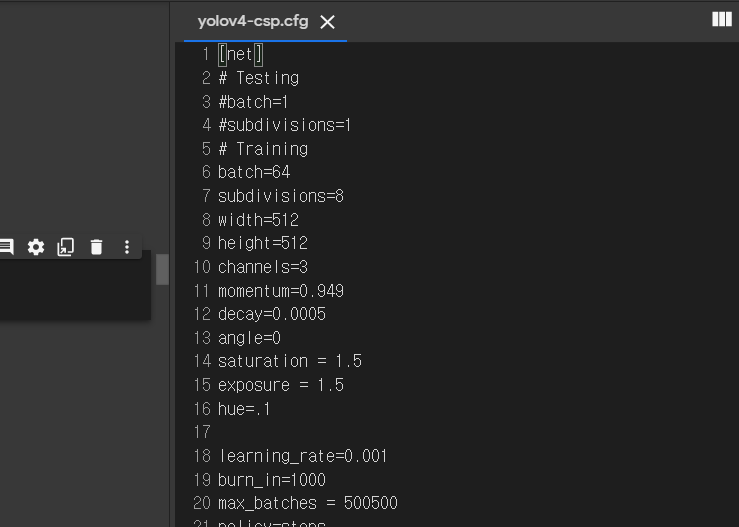

In [ ]:
# 변경사항이 반영이 되었는지 확인하여보자.
%cat /content/darknet/cfg/yolov4-custom.cfg

[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=1
subdivisions=1
width=416
height=416
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 3500
policy=steps
steps=2800,3150
scales=.1,.1

#cutmix=1
mosaic=1

#:104x104 54:52x52 85:26x26 104:13x13 for 416

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=

In [ ]:
#set your custom cfg to test mode 
%cd /content/darknet/cfg
!sed -i 's/batch=64/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-custom.cfg
%cd ..

/content/darknet/cfg
/content/darknet


In [ ]:
%cat /content/darknet/data/sea_data.data

classes = 7
train = data/train.txt
valid = data/valid.txt
test = data/test.txt
names = data/ClassNames.names
backup = backup/

## 5) darknet 구축

(변경 전)

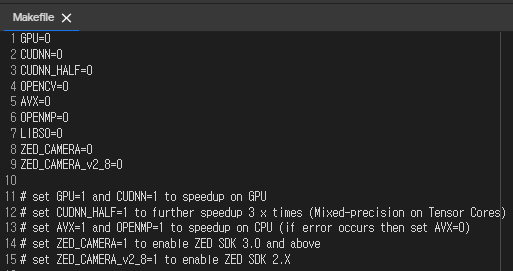

In [ ]:
# GPU, OPENCV, LIBSO을 true로 설정
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

(변경 후)

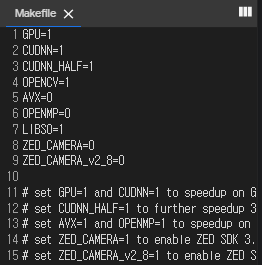

In [ ]:
# 위의 변경된 옵션으로 makefile을 컴파일하면 darknet.py 사용이 가능해진다.
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

## 2) Darknet for Python
 

In [ ]:
from darknet import *
# darknet에 있는 모든 내용을 import함

In [ ]:
# YOLOv4 모델을 로드하여보자.
# 커스텀 모델을 사용할 경우 load_network의 1번째, 3번째 인자를 수정해야 한다.
network, class_names, class_colors = load_network("cfg/yolov4-custom.cfg", "data/sea_data.data", "data/yolov4-custom_best_0.5_1000.weights")

* darknet.py 파일을 확인해보면 load_network 함수의 1번째 인자는 config file, 2번째 인자는 data file, 3번째 인자는 weights에 해당하는 것을 알 수 있다.
* 또한 load_network 함수는 학습된 모델(=network), class 이름(=class names), class 별 고유 색상(=class colors)를 반환하는 것을 알 수 있다.
* class colors는 이후 boundary box를 이미지 위에 시각화할 때 사용할 색상이다.

In [ ]:
# class의 종류 예시
class_names

['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'stingray', 'starfish']

In [ ]:
# class color의 예시
class_colors['fish']

(93, 85, 104)

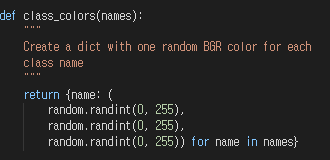

* 3가지의 값은 각각 B(Black), G(Green), R(Red)에 해당하는 것은 알 수 있다.
* 또한 색상은 랜덤하게 배정이 되었으며, 딕셔너리 형태로 클래스 별 생상 데이터가 저장되었음을 알 수 있다.
* 참고: OpenCV는 일반적인 RGB 순서가 아닌 BGR을 사용한다.

In [ ]:
# 네트워크의 width와 height을 계산
width = network_width(network)
height = network_height(network)

print(width, height)

416 416


`cv2.cvtColor(BGR이미지, cv2.COLOR_BGR2RGB)`

* 컬러 사진을 OpenCV에서는 BGR 순서로 인식하지만 일반적으로 matplotlib 등에서 사진을 출력하기 위하여는 이미지가 RGB 순서로 저장되어 있어야 한다.
* 따라서, 위와 같은 이유등을 위하여 이미지 순서를 RGB로 변환할 때 cvtColor을 사용한다.

`cv2.resize(이미지, dsize, fx, fy, interplolation)`
* 이미지의 크기를 조정한다.
* dsize는 결과 영상의 크기를 나타내며 (width, height)의 튜플 형태를 띈다.
* dsize가 (0,0)일 경우 fx와 fy를 통해 크기를 조정한다. fx와 fy는 스케일 비율을 나타낸다.
* interpolation은 보간법을 지정한다. 보간법은 이미지 확대 또는 축소 과정에서 이미지 픽셀의 유실이 일어났을 때, 주변 픽셀값을 이용하여 이를 채워넣는 방법을 의미한다. cv2.INTER_NEAREST,cv2.INTER_LINEAR, cv2.INTER_CUBIC 등이 있으며, INTER_LINEAR의 방법이 속도가 빠를 뿐더러 성능이 좋기 때문에 가장 많이 사용된다.

In [ ]:
# object detection을 수행하는 darknet_helper 함수를 살펴보자.

def darknet_helper(img, width, height):
  # 이미지를 darknet style로 전처리 -> darknet_image 변수에 저장
  darknet_image = make_image(width, height, 3)
  # input image를 BRG에서 RGB 순서로 변환
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # input image의 size를 512x512로 변환 (network에서 받아들이는 이미지의 크기가 512x512였기 때문에)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # bounding box의 크기를 조정하기 위하여 이미지 크기 비율을 계산 
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width # 원본 이미지 width/ network width
  height_ratio = img_height/height # 원본 이미지 height/ network height

  # darknet stlye로 전처리된 이미지로 모델을 작동시켜 detection을 수행
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  # detect_image 함수 실행
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)

  return detections, width_ratio, height_ratio

* darknet_helper은 이미지 전처리(RGB로 변환, 크기 조정)부터 bounding box의 비율 계산, detection까지 모두 수행하는 함수이다. 

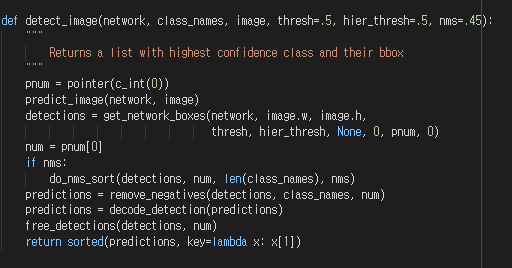

* derknet_helper에서 불러온 detect_image 함수를 더 자세히 살펴보자. 함수는 darknet.py에서 찾을 수 있다.
* detect_image는 이미지, netwok height, netwok width를 인자로 입력 받아1) bounding box와 2) 가장 높은 confidence를 가지는 클래스를 반환한다. 

In [ ]:
# 파일 업로드 기능 실행
files.upload()

Saving 004.png to 004.png


{'004.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xa0\x00\x00\x01\xa0\x08\x06\x00\x00\x00\xec6\xb3Y\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00\x04gAMA\x00\x00\xb1\x8f\x0b\xfca\x05\x00\x00\x00\tpHYs\x00\x00\x0e\xc3\x00\x00\x0e\xc3\x01\xc7o\xa8d\x00\x00\xff\xa5IDATx^\xc4\xfdu\x94e\xc7\x95\xee\x8b\x96\xdd\xb6\xdbm\x90T\xcc\x90\xcc\xcc\xcc\xcc\xb0\x93\x999\xb3\x98\x99\x99\x19UU\x92J\xccL\x96E\x96,\x96,3v\xb7\xed\xee\xe3>}\xcey\xe3\xde\xf7\xcf\x1bc\xbe\xf9\xcd\xb5\xe7\xce\xc8U;\xabJ\x86{\xff\xf8F\xc4\x8aXk\xed]%U\xfc\xf67cF\xc4\x94o\xce\xc9$\xe8\xeb\xb3-}\x8d\xeb\xd0\x949\xd94ev\x16\xfd\xd3\xbc\\\xfa\x9eW\x19M\xf5\xaa\xa2\x85a\xad\xb40\xa8\x89\x1a\xfa\xce\xd2\x8a-O\xd1\xc8\xbaG\xa8\xa8v7e\x96n\xa2\xc8\xd4\x11\xf2\x0eo\xa3\x85\x01\xf5\xb4(\xb0\xc1\xa5\x05\xfeu.\xa1oB\x7fP\x1dy\x865r\xbd\x85\xfc\xc3\xd7RH\xd4n\n\x8b\xddM\x85Ug\xa8m\xf84\xd5\xf5m\xa6%\x91\xa9\x14\x98\\H\x8bB\x8a\xe5\xde\xd4\x82\xad\x94\x90\xb5\x89\x16\x05\xb4\xd2\\o~G@;-\xf2\xef\x1c\x17\xaeY\x8b\x03;DK\x82

`cv2.imread(이미지 경로, 모드)`
* 이미지를 BGR 형식으로 읽는 함수이다.
*  모드로는 IMREAD_UNCHAGNED (=원본), IMREAD_GRAYSCALE(=흑백), IMREAD_COLOR (=BGR 이미지), IMREAD_REDUCED_GRAYSCALE_2 (=2/1 크기의 흑백 이미지) 등이 있다. (기본 값 = IMREAD_UNCHAGED)


`matplotlib.pyplot.imshow(RGB 데이터 또는 2d scalaer 데이터)`

* imread() 함수를 사용하여 jpg 등 이미지 파일을 읽어온 후, imshow() 함수를 사용하여 이미지를 출력할 수 있다.


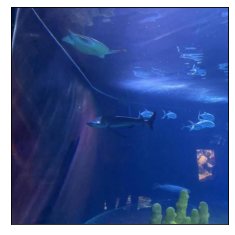

In [ ]:
# 이미지 불러오기
image = cv2.imread('/content/darknet/004.png')
#RGB 이미지를 BGR로 변환
imagee = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# 이미지 출력
plt.imshow(imagee) 
plt.xticks([]) # x축 눈금 (빈칸으로 두어 아무것도 표기되지 않도록 함)
plt.yticks([]) # y축 눈금 (빈칸으로 두어 아무것도 표기되지 않도록 함)
plt.show() 

## 3) YOLOv4 Example on Test Image
 모델이 성공적으로 load되었는지 샘플 이미지에 test하여보자.

In [ ]:
# darknet_helper 함수에 앞서 읽은 이미지와 network height, width를 입력
detections, width_ratio, height_ratio = darknet_helper(imagee, width, height)

In [ ]:
# detection 결과 확인
detections

[('fish',
  '98.27',
  (342.6751403808594,
   230.0330810546875,
   41.168148040771484,
   15.517158508300781)),
 ('fish',
  '99.65',
  (373.4637145996094,
   209.1554412841797,
   33.45421600341797,
   17.539445877075195)),
 ('fish',
  '99.86',
  (300.60498046875,
   205.6016387939453,
   31.143348693847656,
   21.760295867919922)),
 ('shark',
  '99.95',
  (209.05438232421875,
   220.7602081298828,
   132.68939208984375,
   76.60240173339844)),
 ('fish',
  '99.97',
  (363.2937316894531,
   224.51889038085938,
   54.74577713012695,
   20.345911026000977))]

* 튜플 형태 ("클래스 이름", class confidence, bounding box)로 결과가 저장된 것을 확인할 수 있다.
* bounding box로 나온 4가지 수치는 center x, center y, width, height에 해당한다. 

In [ ]:
width_ratio, height_ratio

(1.0, 1.0)

`cv2.rectangle(image, start, end, color, thickness)`
* 이미지에 start와 end를 연결하는 사각형을 그린다.
* image는 사각형을 그릴 이미지를 입력하는 인자이다.
* start는 top-left corner의 좌표를 입력하는 인자이다.
* end는 bottom-right corner의 좌표를 입력하는 인자이다.

`cv2.putText(img, text, org, font, fontSacle, color)`
* 이미지에 text를 입력한다.
* text는 텍스트를 입력하는 인자이다.
* org는 테스트를 표시할 위치를 입력하는 인자로 문자열의 bottom-left corner 좌표를 입력한다.

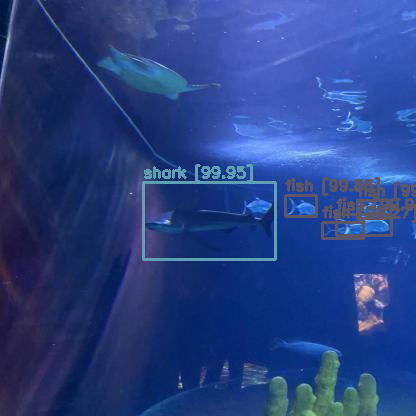

In [ ]:
# detection 결과 시각화

for label, confidence, bbox in detections:
  # center x, center y, width, height로 반환 받은 boundary box를 corner 정보 (left, top, right, bottom)로 변환
  left, top, right, bottom = bbox2points(bbox)
  # 앞서 계산한 이미지 비율을 사용하여 boundary box의 크기를 조정
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  # boundary box 좌표에 해당하는 사각형을 이미지 위에 그림
  cv2.rectangle(imagee, (left, top), (right, bottom), class_colors[label], 2)
  # 클래스 이름과 confidence level을 사각형 위에 입력
  cv2.putText(imagee, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)

# boundary box를 추가한 이미지 출력
#RGB 이미지를 BGR로 변환
image = cv2.cvtColor(imagee, cv2.COLOR_RGB2BGR)
cv2_imshow(image)

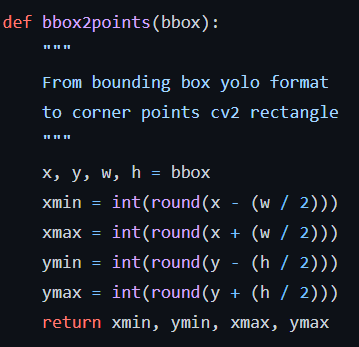

* center x, center y, width, height로 반환 받은 boundary box를 corner 정보로 변환하는 함수는 위와 같다. 